# Tester le modèle de prédiction

In [45]:
import tensorflow as tf
from pathlib import Path

IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 64

# Liste des chemins vers les datasets
dataset_paths = [
    './Tunisian Horses Database THoDBRL 2015/Tunisian Horses Database THoDBRL 2015/Part1/Base image',
    './Tunisian Horses Database THoDBRL 2015/Tunisian Horses Database THoDBRL 2015/Part1/Croped Images',
    './Tunisian Horses Database THoDBRL 2015/Tunisian Horses Database THoDBRL 2015/Part2/Base image',
    './Tunisian Horses Database THoDBRL 2015/Tunisian Horses Database THoDBRL 2015/Part2/Croped Images',
    './Tunisian Horses Database THoDBRL 2015/Tunisian Horses Database THoDBRL 2015/Part3/Base image',
    './Tunisian Horses Database THoDBRL 2015/Tunisian Horses Database THoDBRL 2015/Part3/Croped Images',
    './Tunisian Horses Database THoDBRL 2015/Tunisian Horses Database THoDBRL 2015/Part4/Base image',
    './Tunisian Horses Database THoDBRL 2015/Tunisian Horses Database THoDBRL 2015/Part4/Croped Images',
    './Tunisian Horses Database THoDBRL 2015/Tunisian Horses Database THoDBRL 2015/Part5/Base image',
    './Tunisian Horses Database THoDBRL 2015/Tunisian Horses Database THoDBRL 2015/Part5/Croped Images'
]

# Charger tous les datasets
dataset_list = [
    tf.keras.utils.image_dataset_from_directory(
        Path(path),
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        label_mode='int',  # Labels en tant qu'entiers
        color_mode='rgb',
        shuffle=True,
        seed=123,
    ) for path in dataset_paths
]


Found 300 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 299 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 210 files belonging to 7 classes.
Found 210 files belonging to 7 classes.


In [46]:
# Fusionner les datasets
train_ds = dataset_list[0]
for ds in dataset_list[1:]:
    train_ds = train_ds.concatenate(ds)

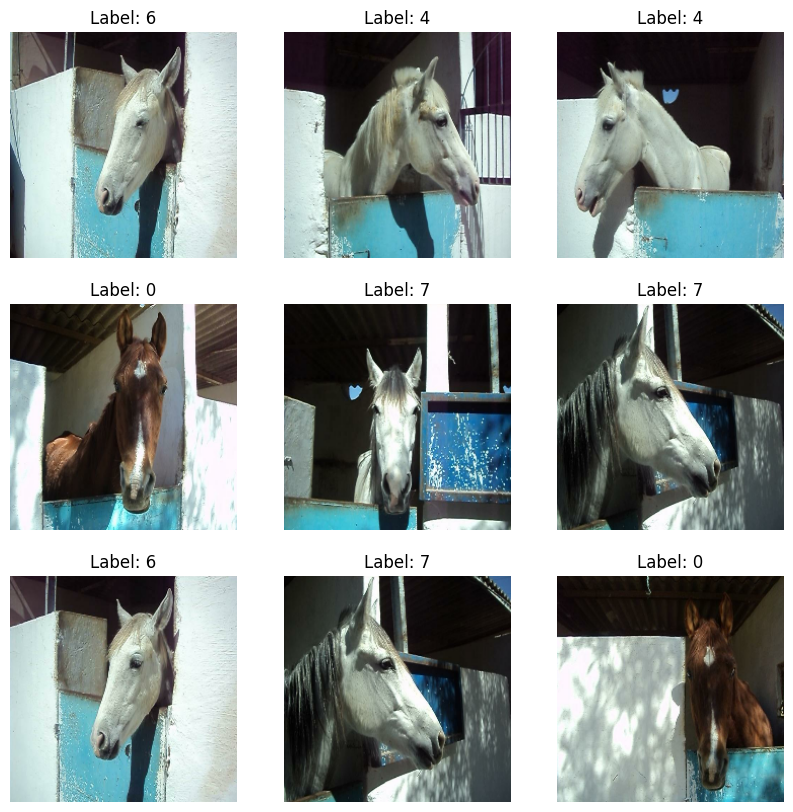

In [47]:
# Vérification : Afficher quelques images du dataset fusionné
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):  # Prend un batch (64 images ici)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Convertir en uint8 pour l'affichage
        plt.title(f'Label: {labels[i].numpy()}')
        plt.axis('off')

    plt.show()

In [48]:
import pandas as pd

def dataset_to_dataframe(dataset):
    """Convertit un dataset TensorFlow en un DataFrame Pandas avec images et labels."""
    
    image_list = []
    label_list = []

    # Parcourir tous les batchs du dataset
    for images, labels in dataset:
        image_list.extend(images.numpy())  # Convertir les images en NumPy et ajouter à la liste
        label_list.extend(labels.numpy())  # Convertir les labels en NumPy et ajouter à la liste

    # Créer un DataFrame avec les images et labels
    df = pd.DataFrame({"image": image_list, "label": label_list})

    return df

In [49]:
# Convertir train_ds en DataFrame
df_train = dataset_to_dataframe(train_ds)

# Afficher les premières lignes du DataFrame
print(df_train.head())

                                               image  label
0  [[[2.0, 2.0, 4.0], [2.0, 2.0, 4.0], [2.0, 2.0,...      9
1  [[[43.285713, 19.285715, 35.285713], [44.64285...      3
2  [[[24.530613, 8.530612, 18.530613], [25.908163...      7
3  [[[3.0, 1.0, 4.0], [3.0, 1.0, 4.0], [3.0, 1.0,...      9
4  [[[28.071428, 9.071428, 28.071428], [26.428572...      4


In [50]:
images_cheval_1 = df_train[df_train['label'] == 1]
images_cheval_2 = df_train[df_train['label'] == 2]

In [51]:
import keras
from tensorflow.keras.models import Model

# Charger le modèle complet sauvegardé
loaded_model = keras.saving.load_model("model.h5")

# Créer un nouveau modèle qui prend en entrée le même input,
# mais dont la sortie est la couche d'embeddings (nommée "embeddings")
model = Model(inputs=loaded_model.input, 
                        outputs=loaded_model.get_layer("embeddings").output)

In [57]:
# Afficher la position dans df du cheval avec le label 1)
df_train[df_train['label'] == 1].index

Index([  15,   36,   45,   47,   55,   56,   73,   86,   96,  105,
       ...
       2779, 2780, 2786, 2787, 2790, 2794, 2796, 2803, 2806, 2813],
      dtype='int64', length=300)

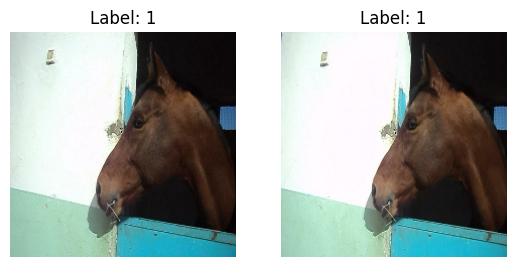

In [62]:
# Cheval 1 Image 1
plt.subplot(1, 2, 1)
plt.imshow(df_train.iloc[36]['image'].astype("uint8"))
plt.title(f'Label: {df_train.iloc[36]["label"]}')
plt.axis('off')

# Cheval 1 Image 2
plt.subplot(1, 2, 2)
plt.imshow(df_train.iloc[47]['image'].astype("uint8"))
plt.title(f'Label: {df_train.iloc[47]["label"]}')
plt.axis('off')
plt.show()

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input

def preprocess_image(image):
    """
    Redimensionne, normalise et ajoute une dimension batch à l'image.
    
    Args:
        image (numpy.ndarray): Image au format (hauteur, largeur, canaux)
        
    Returns:
        numpy.ndarray: Image prétraitée au format (1, 224, 224, 3)s
    """
    # Redimensionner l'image pour VGG16
    image_resized = cv2.resize(image, (224, 224))
    # Ajouter une dimension batch
    image_array = np.expand_dims(image_resized, axis=0)
    # Appliquer la normalisation spécifique à VGG16
    return preprocess_input(image_array)

In [63]:
# Calculer le cosinus de similarité entre deux vecteurs

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Exemple de 2 embeddings de taille 512
image1_1 = df_train.iloc[36]['image']
image1_69 = df_train.iloc[47]['image']

embedding1 = np.vstack(model.predict(preprocess_image(image1_1), verbose=0))
embedding2 = np.vstack(model.predict(preprocess_image(image1_69), verbose=0))


# Calcul de la similarité cosinus
similarity = cosine_similarity(embedding1, embedding2)

print(f"Similarité cosinus : {similarity[0][0]}")

Similarité cosinus : 0.975877046585083


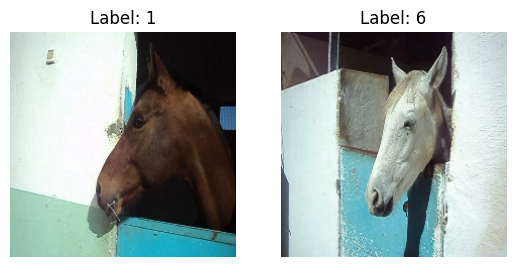

In [55]:
# Cheval 1 Image 1
plt.subplot(1, 2, 1)
plt.imshow(df_train.iloc[36]['image'].astype("uint8"))
plt.title(f'Label: {df_train.iloc[36]["label"]}')
plt.axis('off')

# Cheval 1 Image 2
plt.subplot(1, 2, 2)
plt.imshow(df_train.iloc[100]['image'].astype("uint8"))
plt.title(f'Label: {df_train.iloc[100]["label"]}')
plt.axis('off')
plt.show()

In [56]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Exemple de 2 embeddings de taille 512
image1_1 = df_train.iloc[36]['image']
image1_69 = df_train.iloc[100]['image']

embedding1 = np.vstack(model.predict(preprocess_image(image1_1), verbose=0))
embedding2 = np.vstack(model.predict(preprocess_image(image1_69), verbose=0))


# Calcul de la similarité cosinus
similarity = cosine_similarity(embedding1, embedding2)

print(f"Similarité cosinus : {similarity[0][0]}")

Similarité cosinus : 0.6975795030593872
